In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import ADASYN
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, SCORERS
import matplotlib as plt
%matplotlib inline
from matplotlib import rcParams
import pandas as pd
import numpy as np
import pprint as pp
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import seaborn as sns
import pprint as pp

In [3]:
# Loading in the dataframe, then removing the useless column
stats = pd.read_csv('stats_1.6.csv')
stats.drop(labels='Unnamed: 0', axis=1, inplace=True)
stats.head()
stats.columns

Index(['Player', 'MVP', 'Year', 'Age', 'TmWin', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'FG/G', 'FGA/G', 'FG%', '3P/G', '3PA/G', '3P%', '2P/G', '2PA/G', '2P%',
       'eFG%', 'FT/G', 'FTA/G', 'FT%', 'ORB/G', 'DRB/G', 'TRB/G', 'AST/G',
       'STL/G', 'BLK/G', 'TOV/G', 'PF/G', 'PPG', 'Impact'],
      dtype='object')

# Setting up the features and target
Previously, I used NBA data from 1984 season onwards. One of the problem with this was that there were significant playstyle shifts over this period. This time round, I'll try using data from 1996 onwards - 1996 is the first year of Michael Jordan's second 3-peat. I use 1996 arbitrarily to denote the change in playstyle "eras", since Michael Jordan was a dominant wing player in a otherwise "big" league. 

Of course, during this time period, there were still dominant "bigs" such as Shaquille O'Neal, Tim Duncan, Yao Ming or Dwight Howard. But as a whole, the NBA has started gravitating towards dominant wing players as their star. Players of such mold include Kobe Bryant, Allen Iverson, Tracy McGrady, Steve Nash, and more recently Stephen Curry. 

Within this time period, notwithstanding the big-wing divide, there has also been significant differences in how teams approached the game. For instance, before Mike D'Antoni/Steve Nash's revolutionary Pheonix Suns, the game was mostly centered on 'hero-ball', where teams focused their entire offence on one star player who would dominate the ball in their team's offensive possessions. Nash's Suns broke this mold by playing an up-tempo style basketball and his team also took a significantly larger amount of 3-pointers than other teams. 

The next big shift in playstyle came when Stephen Curry, together with Klay Thompson came into prominence. Their prowess with the 3-point shot led teams in the league to embrace shooting more 3-pointers. Today, the game can hardly be said to bear much similarity with the game during Jordan's era.

However, for this iteration of the model, I'll overlook these playstyle differences and hope that the league's shift in emphasis to wing players will carry the model's performance. If it does not, I'll probably try to carry out further tweaks in this regard.

In [4]:
# Setting up the dataset
stats_9617 = stats[(stats['Year'] >= 1996) & (stats['Year'] <= 2017)]

The number of non-MVP candidates are:  9712
The number of MVP candidates are:  272
Baseline Accuracy:  0.9727564102564102


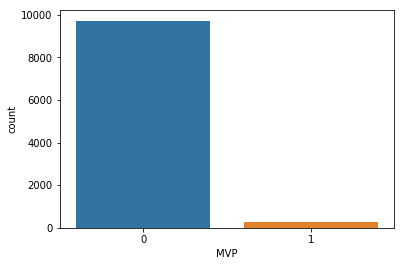

In [5]:
# Checking the distribution of MVP candidates vs non-MVP candidates
sns.countplot(x='MVP', data=stats_9617)

print('The number of non-MVP candidates are: ', stats_9617[stats_9617['MVP'] == 0]['MVP'].count())
print('The number of MVP candidates are: ', stats_9617[stats_9617['MVP'] == 1]['MVP'].count())
print('Baseline Accuracy: ', 9712/(9712 + 272))

In [6]:
# Preparing the predictors for Logistic Regression
# Naming the predictors and target variables X1, y1
X = stats_9617[['BPM', 'TOV/G', 'PF/G', 'TS%', 'AST/G', 'VORP', 'BLK/G', 'PPG', 'TRB/G', 'Impact', 'PER']]
y = stats_9617['MVP']

In [7]:
# Scaling data with Standard Scaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

# Scaled data
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=0)

# Unscaled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Random Forest Classifier with ADASYN

Conclusion:
1. Scaling doesn't seem to perform well with this dataset
2. Best performing is unscaled, optimized for recall_micro (0.75 recall)

In [8]:
# Applying ADASYN on the dataset
ada = ADASYN(random_state=0)

# ADASYN Scaled training set
aXs_train, ays_train = ada.fit_sample(Xs_train, y_train)

# Unscaled training set
aX_train, ay_train = ada.fit_sample(X_train, y_train)

Part A: Attempting with scaled dataset

In [106]:
# Setting up the random forest hyperparamters grid, optimizing for recall_micro
rfc = RandomForestClassifier()

rfc1_params = {'n_estimators':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 'max_features':[1,2,3,4,5,6,7,8,9,10,11], 'criterion':['entropy']}

rfc1_gridsearch = GridSearchCV(rfc, rfc1_params, cv=5, verbose=1, scoring='recall_micro', n_jobs=-1)

rfc1_gridsearch.fit(aXs_train, ays_train)

print(rfc1_gridsearch.best_params_)
print(rfc1_gridsearch.best_score_)
pp.pprint(rfc1_gridsearch.cv_results_)

Fitting 5 folds for each of 275 candidates, totalling 1375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1375 out of 1375 | elapsed:  4.3min finished


{'criterion': 'entropy', 'max_features': 3, 'n_estimators': 23}
0.9787644787644788
{'mean_fit_time': array([0.02732663, 0.06203294, 0.07579632, 0.08676691, 0.10491867,
       0.12985249, 0.14401474, 0.16296391, 0.18969092, 0.21302915,
       0.22140694, 0.23138161, 0.25252409, 0.27566228, 0.30059547,
       0.31176586, 0.34188509, 0.36382613, 0.38038216, 0.40292211,
       0.40631347, 0.42665892, 0.44042149, 0.47692437, 0.49826713,
       0.03710089, 0.07220635, 0.10711317, 0.1368341 , 0.177525  ,
       0.21821628, 0.24175258, 0.26848001, 0.29161935, 0.32453165,
       0.37878604, 0.39135337, 0.43503566, 0.4685463 , 0.51980882,
       0.54534082, 0.55810599, 0.62193542, 0.64248056, 0.68297234,
       0.72466059, 0.75198774, 0.79866328, 0.87226653, 0.99773116,
       0.062433  , 0.12466526, 0.18909369, 0.23856173, 0.28463726,
       0.34786882, 0.41628551, 0.45218954, 0.51023488, 0.57127156,
       0.60857162, 0.66841116, 0.74540496, 0.79068418, 0.84035134,
       0.89959359, 0.9502575

In [9]:
# Setting up a function for random forest
def model_rfc(model, Xtrain, ytrain, Xtest, ytest):
    
    # Fitting the model
    model_fit = model.fit(Xtrain, ytrain)
    
    # Checking cross-validation scores
    print('Cross-Validation Scores: ', cross_val_score(model_fit, Xtrain, ytrain, cv=5))
    print('Mean Cross-Validation Score: ', np.mean(cross_val_score(model_fit, Xtrain, ytrain, cv=5)))
    
    # Constructing confusion matrix
    predictions = model_fit.predict(Xtest)
    predictions_proba = model_fit.predict_proba(Xtest)
    print(confusion_matrix(ytest, predictions))
    print(classification_report(ytest, predictions))
    print('AUC Score: ', roc_auc_score(ytest, predictions_proba[:,1]))


In [30]:
# Not precise enough, there's alot of false positives

rfc1 = RandomForestClassifier(criterion='entropy', max_features=3, n_estimators=23, n_jobs=-1, random_state=0)
model_rfc(rfc1, aXs_train, ays_train, X_test, y_test)

Cross-Validation Scores:  [0.97298167 0.97587649 0.97297297 0.97972321 0.98455101]
Mean Cross-Validation Score:  0.9772210692449008
[[1868   77]
 [  28   24]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1945
           1       0.24      0.46      0.31        52

   micro avg       0.95      0.95      0.95      1997
   macro avg       0.61      0.71      0.64      1997
weighted avg       0.97      0.95      0.96      1997

AUC Score:  0.921534506624481


In [108]:
# Setting up the random forest hyperparamters grid, optimizing for f1_micro
rfc = RandomForestClassifier()

rfc2_params = {'n_estimators':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 'max_features':[1,2,3,4,5,6,7,8,9,10,11], 'criterion':['entropy']}

rfc2_gridsearch = GridSearchCV(rfc, rfc2_params, cv=5, verbose=1, scoring='f1_micro', n_jobs=-1)

rfc2_gridsearch.fit(aXs_train, ays_train)

print(rfc2_gridsearch.best_params_)
print(rfc2_gridsearch.best_score_)
pp.pprint(rfc2_gridsearch.cv_results_)

Fitting 5 folds for each of 275 candidates, totalling 1375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 590 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1375 out of 1375 | elapsed:  4.7min finished


{'criterion': 'entropy', 'max_features': 3, 'n_estimators': 23}
0.9794723294723294
{'mean_fit_time': array([0.02712564, 0.05345707, 0.071807  , 0.08676777, 0.1077117 ,
       0.12526436, 0.15119567, 0.1621665 , 0.17193952, 0.20485201,
       0.22419991, 0.23457136, 0.26169891, 0.26908059, 0.31216478,
       0.32213774, 0.33689942, 0.34487691, 0.36562166, 0.40192494,
       0.39813499, 0.44859939, 0.45438356, 0.46555529, 0.50664444,
       0.03710089, 0.0680172 , 0.10092907, 0.13603654, 0.17094269,
       0.20565   , 0.24554267, 0.26608839, 0.2966054 , 0.33250999,
       0.35106001, 0.39813418, 0.43124652, 0.4531878 , 0.51003561,
       0.51960988, 0.55272098, 0.57246833, 0.62552619, 0.65245476,
       0.69514022, 0.71748023, 0.75158911, 0.78689485, 0.82140188,
       0.05225949, 0.09993215, 0.14281712, 0.19787054, 0.23237734,
       0.28124714, 0.33510308, 0.36621966, 0.4164856 , 0.46834674,
       0.51681685, 0.58304024, 0.61076598, 0.65684285, 0.75916924,
       0.94267826, 0.9993268

In [10]:
# Optimizing for f1_micro is the same as doing it for recall_micro

rfc2 = RandomForestClassifier(criterion='entropy', max_features=3, n_estimators=23, n_jobs=-1, random_state=0)
model_rfc(rfc2, aXs_train, ays_train, X_test, y_test)

Cross-Validation Scores:  [0.97298167 0.97587649 0.97297297 0.97972321 0.98455101]
Mean Cross-Validation Score:  0.9772210692449008
[[1868   77]
 [  28   24]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1945
           1       0.24      0.46      0.31        52

   micro avg       0.95      0.95      0.95      1997
   macro avg       0.61      0.71      0.64      1997
weighted avg       0.97      0.95      0.96      1997

AUC Score:  0.921534506624481


In [110]:
# Setting up the random forest hyperparamters grid, optimizing for precision_micro
rfc = RandomForestClassifier()

rfc3_params = {'n_estimators':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 'max_features':[1,2,3,4,5,6,7,8,9,10,11], 'criterion':['entropy']}

rfc3_gridsearch = GridSearchCV(rfc, rfc3_params, cv=5, verbose=1, scoring='precision_micro', n_jobs=-1)

rfc3_gridsearch.fit(aXs_train, ays_train)

print(rfc3_gridsearch.best_params_)
print(rfc3_gridsearch.best_score_)
pp.pprint(rfc3_gridsearch.cv_results_)

Fitting 5 folds for each of 275 candidates, totalling 1375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 594 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1375 out of 1375 | elapsed:  4.7min finished


{'criterion': 'entropy', 'max_features': 8, 'n_estimators': 25}
0.9788931788931788
{'mean_fit_time': array([0.02572894, 0.05425429, 0.09275141, 0.08995967, 0.11509185,
       0.1428174 , 0.14580984, 0.16077003, 0.20983648, 0.22180586,
       0.23277688, 0.25751119, 0.29301548, 0.27406745, 0.34268284,
       0.31775022, 0.33251038, 0.37160463, 0.43762808, 0.46515584,
       0.40372   , 0.47991581, 0.47233629, 0.47413135, 0.50105948,
       0.03849692, 0.06821647, 0.09893565, 0.15717869, 0.18909435,
       0.20564942, 0.26369486, 0.29501061, 0.30338764, 0.36262999,
       0.40651188, 0.41030197, 0.44700394, 0.52399807, 0.50185719,
       0.55391822, 0.57127118, 0.5840374 , 0.6428802 , 0.71628332,
       0.71787944, 0.76335793, 0.8012557 , 0.79327769, 0.89041805,
       0.05126252, 0.1059165 , 0.1627636 , 0.19966516, 0.26349497,
       0.31036925, 0.34846745, 0.4007277 , 0.46874537, 0.48490391,
       0.56508708, 0.60976863, 0.65125732, 0.87286458, 0.94507179,
       0.95863552, 1.0647515

In [11]:
# This is just downright awful at predicting for MVPs

rfc3 = RandomForestClassifier(criterion='entropy', max_features=8, n_estimators=25, n_jobs=-1, random_state=0)
model_rfc(rfc3, aXs_train, ays_train, X_test, y_test)

Cross-Validation Scores:  [0.97491155 0.9800579  0.97200772 0.97714837 0.98165433]
Mean Cross-Validation Score:  0.9771559738262562
[[1933   12]
 [  45    7]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1945
           1       0.37      0.13      0.20        52

   micro avg       0.97      0.97      0.97      1997
   macro avg       0.67      0.56      0.59      1997
weighted avg       0.96      0.97      0.96      1997

AUC Score:  0.9067184101245798


Part A: Attempting with unscaled dataset

In [112]:
# Setting up the random forest hyperparamters grid, optimizing for recall_micro
rfc = RandomForestClassifier()

rfc4_params = {'n_estimators':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 'max_features':[1,2,3,4,5,6,7,8,9,10,11], 'criterion':['entropy']}

rfc4_gridsearch = GridSearchCV(rfc, rfc4_params, cv=5, verbose=1, scoring='recall_micro', n_jobs=-1)

rfc4_gridsearch.fit(aX_train, ay_train)

print(rfc4_gridsearch.best_params_)
print(rfc4_gridsearch.best_score_)
pp.pprint(rfc4_gridsearch.cv_results_)

Fitting 5 folds for each of 275 candidates, totalling 1375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 586 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1375 out of 1375 | elapsed:  4.1min finished


{'criterion': 'entropy', 'max_features': 7, 'n_estimators': 15}
0.9839530837146355
{'mean_fit_time': array([0.02632713, 0.0580442 , 0.07819033, 0.09255185, 0.11190014,
       0.12227297, 0.14880176, 0.15099521, 0.19029107, 0.19906735,
       0.21223154, 0.23437238, 0.25152655, 0.29560914, 0.30019693,
       0.33390727, 0.33171234, 0.35544872, 0.38257661, 0.37380023,
       0.40012813, 0.41907821, 0.46395807, 0.47532859, 0.5046495 ,
       0.03989325, 0.06761889, 0.10451989, 0.13783021, 0.16595564,
       0.19009089, 0.24474511, 0.26110096, 0.28882627, 0.32054191,
       0.37000985, 0.39095402, 0.43862591, 0.46156526, 0.50265441,
       0.51801419, 0.55990186, 0.6031858 , 0.62413025, 0.65464845,
       0.68955564, 0.70670867, 0.75099044, 0.80285196, 0.82958097,
       0.05325785, 0.10431972, 0.14580989, 0.19168653, 0.2351697 ,
       0.28403983, 0.33011546, 0.37459688, 0.42845306, 0.46016798,
       0.52379837, 0.55930367, 0.61535401, 0.67020845, 0.72166963,
       0.78130631, 0.8108311

In [12]:
# Definitely better than the scaled edition

rfc4 = RandomForestClassifier(criterion='entropy', max_features=7, n_estimators=15, n_jobs=-1, random_state=0)
model_rfc(rfc4, aX_train, ay_train, X_test, y_test)

Cross-Validation Scores:  [0.97809278 0.98099227 0.9845311  0.98324202 0.98517564]
Mean Cross-Validation Score:  0.9824067621623238
[[1889   56]
 [  13   39]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1945
           1       0.41      0.75      0.53        52

   micro avg       0.97      0.97      0.97      1997
   macro avg       0.70      0.86      0.76      1997
weighted avg       0.98      0.97      0.97      1997

AUC Score:  0.9605101839035002


In [114]:
# Setting up the random forest hyperparamters grid, optimizing for f1_micro
rfc = RandomForestClassifier()

rfc5_params = {'n_estimators':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 'max_features':[1,2,3,4,5,6,7,8,9,10,11], 'criterion':['entropy']}

rfc5_gridsearch = GridSearchCV(rfc, rfc5_params, cv=5, verbose=1, scoring='f1_micro', n_jobs=-1)

rfc5_gridsearch.fit(aX_train, ay_train)

print(rfc5_gridsearch.best_params_)
print(rfc5_gridsearch.best_score_)
pp.pprint(rfc5_gridsearch.cv_results_)

Fitting 5 folds for each of 275 candidates, totalling 1375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 590 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1375 out of 1375 | elapsed:  4.3min finished


{'criterion': 'entropy', 'max_features': 6, 'n_estimators': 11}
0.9840175291615647
{'mean_fit_time': array([0.0255281 , 0.05624866, 0.08497128, 0.09773803, 0.10013156,
       0.12526364, 0.13443933, 0.15558405, 0.19228497, 0.20864162,
       0.2257957 , 0.2401577 , 0.26329556, 0.26907964, 0.3123641 ,
       0.30657935, 0.3223372 , 0.35624704, 0.38197818, 0.40012946,
       0.39554229, 0.44660521, 0.43762903, 0.4721365 , 0.502456  ,
       0.03690157, 0.07140803, 0.09813709, 0.13643522, 0.16755233,
       0.21063657, 0.24614191, 0.26289606, 0.29062161, 0.32692523,
       0.38796134, 0.39574065, 0.42107391, 0.45139184, 0.50824032,
       0.5245966 , 0.5473352 , 0.58822675, 0.62173681, 0.65504689,
       0.68377056, 0.73263998, 0.73962159, 0.76993999, 0.81741314,
       0.05325718, 0.10072889, 0.14820189, 0.19268403, 0.23596778,
       0.30039568, 0.32812195, 0.38137884, 0.42925086, 0.47772131,
       0.53317232, 0.57506142, 0.62133741, 0.68117719, 0.72166963,
       0.79068384, 0.8283830

In [13]:
# Worse than the one optimized by recall

rfc5 = RandomForestClassifier(criterion='entropy', max_features=6, n_estimators=11, n_jobs=-1, random_state=0)
model_rfc(rfc5, aX_train, ay_train, X_test, y_test)

Cross-Validation Scores:  [0.97744845 0.98260309 0.98582017 0.98324202 0.98130841]
Mean Cross-Validation Score:  0.9820844310959463
[[1885   60]
 [  13   39]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1945
           1       0.39      0.75      0.52        52

   micro avg       0.96      0.96      0.96      1997
   macro avg       0.69      0.86      0.75      1997
weighted avg       0.98      0.96      0.97      1997

AUC Score:  0.9618103618746293


In [116]:
# Setting up the random forest hyperparamters grid, optimizing for precision_micro
rfc = RandomForestClassifier()

rfc6_params = {'n_estimators':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 'max_features':[1,2,3,4,5,6,7,8,9,10,11], 'criterion':['entropy']}

rfc6_gridsearch = GridSearchCV(rfc, rfc6_params, cv=5, verbose=1, scoring='precision_micro', n_jobs=-1)

rfc6_gridsearch.fit(aX_train, ay_train)

print(rfc6_gridsearch.best_params_)
print(rfc6_gridsearch.best_score_)
pp.pprint(rfc6_gridsearch.cv_results_)

Fitting 5 folds for each of 275 candidates, totalling 1375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1375 out of 1375 | elapsed:  4.1min finished


{'criterion': 'entropy', 'max_features': 7, 'n_estimators': 19}
0.9842108655023523
{'mean_fit_time': array([0.02533078, 0.05385547, 0.08996034, 0.09275107, 0.10531669,
       0.12147565, 0.14261756, 0.16515841, 0.17592878, 0.1998642 ,
       0.23038416, 0.24693913, 0.27147236, 0.27107496, 0.28882728,
       0.3149569 , 0.34248309, 0.3594377 , 0.35604782, 0.37699142,
       0.42226958, 0.44580646, 0.44101977, 0.46316056, 0.46734991,
       0.04029202, 0.07300358, 0.10431972, 0.13922763, 0.16814985,
       0.19707198, 0.23995814, 0.27785649, 0.30278916, 0.32931881,
       0.36661878, 0.38576746, 0.41808152, 0.45518217, 0.4966711 ,
       0.52639146, 0.56269317, 0.57466321, 0.62991428, 0.6462709 ,
       0.68676233, 0.70910182, 0.74859695, 0.76515341, 0.83955402,
       0.05166202, 0.09753819, 0.14620872, 0.19388027, 0.23078084,
       0.292417  , 0.32732391, 0.3773891 , 0.41429105, 0.47692418,
       0.52000914, 0.56468883, 0.60857124, 0.66003428, 0.67758718,
       0.77612257, 0.8138219

In [14]:
# Better than f1 score, worse than recall

rfc6 = RandomForestClassifier(criterion='entropy', max_features=7, n_estimators=19, n_jobs=-1, random_state=0)
model_rfc(rfc6, aX_train, ay_train, X_test, y_test)

Cross-Validation Scores:  [0.97744845 0.98228093 0.98517564 0.98356429 0.98517564]
Mean Cross-Validation Score:  0.9827289894049989
[[1887   58]
 [  14   38]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1945
           1       0.40      0.73      0.51        52

   micro avg       0.96      0.96      0.96      1997
   macro avg       0.69      0.85      0.75      1997
weighted avg       0.98      0.96      0.97      1997

AUC Score:  0.9692752620130513


Part C: Test on 2009 NBA data

In [32]:
testing_2019 = stats[stats['Year'] == 2019]
test_2019_X = testing_2019[['BPM', 'TOV/G', 'PF/G', 'TS%', 'AST/G', 'VORP', 'BLK/G', 'PPG', 'TRB/G', 'Impact', 'PER']]
test_2019_y = testing_2019[['MVP']]

In [20]:
# Pretty darn good at predicting 2009's MVPs
model_rfc(rfc4, aX_train, ay_train, test_2019_X, test_2019_y)

Cross-Validation Scores:  [0.97809278 0.98099227 0.9845311  0.98324202 0.98517564]
Mean Cross-Validation Score:  0.9824067621623238
[[507  13]
 [  0  10]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       520
           1       0.43      1.00      0.61        10

   micro avg       0.98      0.98      0.98       530
   macro avg       0.72      0.99      0.80       530
weighted avg       0.99      0.98      0.98       530

AUC Score:  0.9888461538461539


In [21]:
probability_rfc_2019 = pd.DataFrame(rfc4.predict_proba(test_2019_X))
probability_rfc_2019 = probability_rfc_2019.loc[:,1:]
probability_rfc_2019.columns = ['Predicted MVP Probability']

predictions_rfc_2019 = pd.DataFrame(rfc4.predict(test_2019_X))
predictions_rfc_2019.columns = ['Predicted MVP']

real_mvp = pd.DataFrame(test_2019_y)
real_mvp.columns = ['Real MVP']
real_mvp.reset_index(inplace=True)
real_mvp = real_mvp[['Real MVP']]

predictors_rfc_2019 = test_2019_X.copy(deep=True)
predictors_rfc_2019.reset_index(inplace=True)
predictors_rfc_2019.columns = ['Player', 'BPM', 'TOV/G', 'PF/G', 'TS%', 'AST/G', 'VORP', 'BLK/G', 'PPG', 'TRB/G', 'Impact', 'PER']

MVP_2019_rfc = pd.concat([predictors_rfc_2019, real_mvp, predictions_rfc_2019, probability_rfc_2019], axis=1)

MVP_2019_rfc[MVP_2019_rfc['Predicted MVP'] == 1].sort_values(by=['Predicted MVP Probability'], ascending=False)

,Player,BPM,TOV/G,PF/G,TS%,AST/G,VORP,BLK/G,PPG,TRB/G,Impact,PER,Real MVP,Predicted MVP,Predicted MVP Probability
454,15101,6.3,2.78,2.41,0.641,5.23,4.9,0.36,27.26,5.35,708.083890,24.4,1,1,1.000000
322,9856,6.4,2.57,2.49,0.592,6.93,4.7,0.51,23.82,5.00,546.619500,24.3,0,1,1.000000
407,12714,5.5,2.66,2.78,0.583,4.13,5.3,0.44,28.04,8.16,803.387306,23.3,1,1,1.000000
87,3452,5.5,2.65,1.85,0.588,6.89,5.4,0.43,25.84,4.64,895.758171,23.7,1,1,1.000000
390,12348,6.4,1.99,1.96,0.573,3.84,5.3,1.11,20.81,12.00,599.951220,25.5,0,1,1.000000
225,7150,11.7,4.96,3.13,0.616,7.51,9.9,0.74,36.13,6.64,1219.545755,30.6,1,1,1.000000
388,12329,9.5,3.10,2.85,0.589,7.25,7.3,0.69,20.05,10.81,753.032195,26.3,1,1,1.000000
323,9877,1.6,1.78,2.21,0.576,2.40,2.5,1.32,21.32,9.19,713.988329,22.9,0,1,1.000000
108,4138,0.9,2.58,2.30,0.542,6.17,2.0,0.47,21.23,6.00,704.223220,19.6,0,1,0.933333
158,5413,3.5,2.12,2.00,0.577,5.51,3.2,0.37,15.91,4.64,618.635122,19.3,0,1,0.933333


In [22]:
MVP_2019_df = MVP_2019_rfc[MVP_2019_rfc['Predicted MVP'] == 1].sort_values(by=['Predicted MVP Probability'], ascending=False)

# Function to display MVP in sequential order
def mvp_displayer(mvp_dataframe):
    mvp_list = []
    for player in mvp_dataframe['Player'].values:
        mvp_list.append(stats.loc[player]['Player'])
    
    mvp_df = pd.DataFrame(mvp_list)
    mvp_df.columns = ['MVP Candidate']
    
    mvp_proba = []
    for proba in mvp_dataframe['Predicted MVP Probability']:
        mvp_proba.append(proba)
    
    proba_df = pd.DataFrame(mvp_proba)
    proba_df.columns = ['Predicted MVP Probability']
    
    final_df = pd.concat([mvp_df, proba_df], axis=1)
    
    return final_df

In [23]:
mvp_displayer(MVP_2019_df)

,MVP Candidate,Predicted MVP Probability
0,Stephen Curry,1.000000
1,Kyrie Irving,1.000000
2,Paul George,1.000000
3,Damian Lillard,1.000000
4,Nikola Vucevic,1.000000
5,James Harden,1.000000
6,Nikola Jokic,1.000000
7,LaMarcus Aldridge,1.000000
8,DeMar DeRozan,0.933333
9,Eric Bledsoe,0.933333


Part D: Test on 2019 NBA dataset

In [24]:
testing_2018 = stats[stats['Year'] == 2018]
test_2018_X = testing_2018[['BPM', 'TOV/G', 'PF/G', 'TS%', 'AST/G', 'VORP', 'BLK/G', 'PPG', 'TRB/G', 'Impact', 'PER']]
test_2018_y = testing_2018[['MVP']]

In [25]:
# Model didn't perform so well here, it missed out 3 MVPs
model_rfc(rfc4, aX_train, ay_train, test_2018_X, test_2018_y)

Cross-Validation Scores:  [0.97809278 0.98099227 0.9845311  0.98324202 0.98517564]
Mean Cross-Validation Score:  0.9824067621623238
[[514  10]
 [  3  10]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       524
           1       0.50      0.77      0.61        13

   micro avg       0.98      0.98      0.98       537
   macro avg       0.75      0.88      0.80       537
weighted avg       0.98      0.98      0.98       537

AUC Score:  0.9869348209042865


In [26]:
probability_rfc_2018 = pd.DataFrame(rfc4.predict_proba(test_2018_X))
probability_rfc_2018 = probability_rfc_2018.loc[:,1:]
probability_rfc_2018.columns = ['Predicted MVP Probability']

predictions_rfc_2018 = pd.DataFrame(rfc4.predict(test_2018_X))
predictions_rfc_2018.columns = ['Predicted MVP']

real_mvp = pd.DataFrame(test_2018_y)
real_mvp.columns = ['Real MVP']
real_mvp.reset_index(inplace=True)
real_mvp = real_mvp[['Real MVP']]

predictors_rfc_2018 = test_2018_X.copy(deep=True)
predictors_rfc_2018.reset_index(inplace=True)
predictors_rfc_2018.columns = ['Player', 'BPM', 'TOV/G', 'PF/G', 'TS%', 'AST/G', 'VORP', 'BLK/G', 'PPG', 'TRB/G', 'Impact', 'PER']

MVP_2018_rfc = pd.concat([predictors_rfc_2018, real_mvp, predictions_rfc_2018, probability_rfc_2018], axis=1)

MVP_2018_rfc[MVP_2018_rfc['Predicted MVP'] == 1].sort_values(by=['Predicted MVP Probability'], ascending=False)

,Player,BPM,TOV/G,PF/G,TS%,AST/G,VORP,BLK/G,PPG,TRB/G,Impact,PER,Real MVP,Predicted MVP,Predicted MVP Probability
317,9876,3.3,1.48,2.15,0.570,2.03,3.3,1.20,23.13,8.47,653.879440,25.0,1,1,1.000000
86,3451,6.7,2.82,1.60,0.594,6.59,5.9,0.37,26.88,4.45,742.500137,25.2,1,1,1.000000
396,12328,7.1,2.80,2.83,0.603,6.11,5.6,0.81,18.47,10.71,518.206479,24.4,0,1,1.000000
324,10170,9.6,4.23,1.66,0.621,9.11,8.9,0.87,27.45,8.65,996.058333,28.6,1,1,1.000000
313,9823,5.9,2.35,2.46,0.598,6.88,5.0,0.24,16.24,5.56,636.832149,19.5,0,1,1.000000
513,16542,4.9,2.92,2.33,0.577,4.31,4.5,0.76,23.13,5.20,702.578049,23.1,1,1,0.933333
217,7149,10.9,4.38,2.35,0.619,8.75,8.3,0.69,30.43,5.40,1094.985640,29.8,1,1,0.933333
299,9401,5.6,3.04,1.96,0.640,5.38,4.5,1.75,26.35,6.82,708.236585,26.0,1,1,0.933333
507,16390,3.6,2.25,1.85,0.561,5.17,2.3,0.33,19.42,5.10,132.649358,21.1,0,1,0.866667
444,14231,8.2,4.76,2.50,0.524,10.25,7.5,0.25,25.35,10.05,969.438049,24.7,1,1,0.866667


In [27]:
# These are the MVP candidates predicted by the model
MVP_2018_df = MVP_2018_rfc[MVP_2018_rfc['Predicted MVP'] == 1].sort_values(by=['Predicted MVP Probability'], ascending=False)
mvp_displayer(MVP_2018_df)

,MVP Candidate,Predicted MVP Probability
0,LaMarcus Aldridge,1.000000
1,Damian Lillard,1.000000
2,Nikola Jokic,1.000000
3,LeBron James,1.000000
4,Kyle Lowry,1.000000
5,Victor Oladipo,0.933333
6,James Harden,0.933333
7,Kevin Durant,0.933333
8,Tyreke Evans,0.866667
9,Russell Westbrook,0.866667


In [28]:
# Checking for those that the model missed out
# Jimmy Butler, Joel Embiid, Stephen Curry
MVP_2018_rfc[(MVP_2018_rfc['Predicted MVP'] == 0) & (MVP_2018_rfc['Real MVP'] == 1)]

,Player,BPM,TOV/G,PF/G,TS%,AST/G,VORP,BLK/G,PPG,TRB/G,Impact,PER,Real MVP,Predicted MVP,Predicted MVP Probability
243,8052,5.0,1.83,1.32,0.590,4.88,3.8,0.41,22.15,5.32,379.622009,23.7,1,0,0.066667
251,8246,2.6,3.71,3.32,0.573,3.16,2.2,1.76,22.94,10.95,531.524341,22.9,1,0,0.466667
464,15100,8.6,3.00,2.24,0.675,6.08,4.4,0.16,26.39,5.12,379.978247,28.2,1,0,0.133333


Part E: Let's try with the standardized dataset even though it didn't perform as well as the non-standardized dataset

In [33]:
# Looks pretty awful to me, not going to try to dig deeper by showing who is the MVP
model_rfc(rfc1, aXs_train, ays_train, test_2019_X, test_2019_y)

Cross-Validation Scores:  [0.97298167 0.97587649 0.97297297 0.97972321 0.98455101]
Mean Cross-Validation Score:  0.9772210692449008
[[500  20]
 [  4   6]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       520
           1       0.23      0.60      0.33        10

   micro avg       0.95      0.95      0.95       530
   macro avg       0.61      0.78      0.65       530
weighted avg       0.98      0.95      0.96       530

AUC Score:  0.9607692307692308
